In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm
import pylab
from sklearn.utils import resample

from statsmodels.graphics. tsaplots import plot_acf
import numpy as np

## Data Understanding

In [ ]:
mood = pd.read_csv('/content/dataset_mood_smartphone.csv', index_col=0)
mood

,id,time,variable,value
1,AS14.01,2014-02-26 13:00:00.000,mood,6.000
2,AS14.01,2014-02-26 15:00:00.000,mood,6.000
3,AS14.01,2014-02-26 18:00:00.000,mood,6.000
4,AS14.01,2014-02-26 21:00:00.000,mood,7.000
5,AS14.01,2014-02-27 09:00:00.000,mood,6.000
...,...,...,...,...
2770399,AS14.30,2014-04-11 07:51:16.948,appCat.weather,8.032
2772465,AS14.30,2014-04-19 11:00:32.747,appCat.weather,3.008
2774026,AS14.30,2014-04-26 10:19:07.434,appCat.weather,7.026
2774133,AS14.30,2014-04-27 00:44:48.450,appCat.weather,23.033


In [ ]:
len(mood['id'].value_counts())

27

We have 27 people

In [ ]:
sorted(mood['id'].value_counts())

[2848,
 3620,
 3982,
 7902,
 9286,
 10886,
 11193,
 11397,
 11889,
 12589,
 14425,
 14430,
 14575,
 14581,
 15745,
 15826,
 16045,
 16390,
 16403,
 17279,
 17311,
 17499,
 18092,
 19276,
 19592,
 21852,
 21999]

They have between 3000 and 20 000 data points 

In [ ]:
set(mood['id'])

{'AS14.01',
 'AS14.02',
 'AS14.03',
 'AS14.05',
 'AS14.06',
 'AS14.07',
 'AS14.08',
 'AS14.09',
 'AS14.12',
 'AS14.13',
 'AS14.14',
 'AS14.15',
 'AS14.16',
 'AS14.17',
 'AS14.19',
 'AS14.20',
 'AS14.23',
 'AS14.24',
 'AS14.25',
 'AS14.26',
 'AS14.27',
 'AS14.28',
 'AS14.29',
 'AS14.30',
 'AS14.31',
 'AS14.32',
 'AS14.33'}

27 people makes sense as number 4, 10, 11, and so on are missing

In [ ]:
set(mood['variable'])

{'activity',
 'appCat.builtin',
 'appCat.communication',
 'appCat.entertainment',
 'appCat.finance',
 'appCat.game',
 'appCat.office',
 'appCat.other',
 'appCat.social',
 'appCat.travel',
 'appCat.unknown',
 'appCat.utilities',
 'appCat.weather',
 'call',
 'circumplex.arousal',
 'circumplex.valence',
 'mood',
 'screen',
 'sms'}

In [ ]:
mood.loc[mood['variable'].isnull()] # I guess this is an error

,id,time,variable,value


In [ ]:
#mood = mood.drop(index = 1609295)
mood.loc[mood['variable'].isnull()] 

,id,time,variable,value


In [ ]:
set(mood['variable'])

{'activity',
 'appCat.builtin',
 'appCat.communication',
 'appCat.entertainment',
 'appCat.finance',
 'appCat.game',
 'appCat.office',
 'appCat.other',
 'appCat.social',
 'appCat.travel',
 'appCat.unknown',
 'appCat.utilities',
 'appCat.weather',
 'call',
 'circumplex.arousal',
 'circumplex.valence',
 'mood',
 'screen',
 'sms'}

In [ ]:
mood['variable'].value_counts()

screen                  96578
appCat.builtin          91288
appCat.communication    74276
appCat.entertainment    27125
activity                22965
appCat.social           19145
appCat.other             7650
circumplex.valence       5643
circumplex.arousal       5643
appCat.office            5642
mood                     5641
call                     5239
appCat.travel            2846
appCat.utilities         2487
sms                      1798
appCat.finance            939
appCat.unknown            939
appCat.game               813
appCat.weather            255
Name: variable, dtype: int64

Not all variables even exist so that makes it a bit easier

But all variables occur quite a couple of times so that is very useful

In [ ]:
mood

,id,time,variable,value
1,AS14.01,2014-02-26 13:00:00.000,mood,6.000
2,AS14.01,2014-02-26 15:00:00.000,mood,6.000
3,AS14.01,2014-02-26 18:00:00.000,mood,6.000
4,AS14.01,2014-02-26 21:00:00.000,mood,7.000
5,AS14.01,2014-02-27 09:00:00.000,mood,6.000
...,...,...,...,...
2770399,AS14.30,2014-04-11 07:51:16.948,appCat.weather,8.032
2772465,AS14.30,2014-04-19 11:00:32.747,appCat.weather,3.008
2774026,AS14.30,2014-04-26 10:19:07.434,appCat.weather,7.026
2774133,AS14.30,2014-04-27 00:44:48.450,appCat.weather,23.033


In [ ]:
mood.loc[mood['value'].isnull()]['variable'].value_counts()

circumplex.valence    156
circumplex.arousal     46
Name: variable, dtype: int64

Not a lot so shouldt be an issue to remove them, but we can discuss this later too

comment Tildi: valence and arousal together make mood so we if either os missing for one time stamp both have to be deleted => not usable; or remove the ones with the missing mood altogether (mood = mood[mood["mood"] > 0])?

In [ ]:
# time and id didnt have nas so this is fine
mood = mood.dropna()
mood.loc[mood['value'].isnull()] 

,id,time,variable,value


In [ ]:
mood = mood.drop_duplicates()
mood

,id,time,variable,value
1,AS14.01,2014-02-26 13:00:00.000,mood,6.000
2,AS14.01,2014-02-26 15:00:00.000,mood,6.000
3,AS14.01,2014-02-26 18:00:00.000,mood,6.000
4,AS14.01,2014-02-26 21:00:00.000,mood,7.000
5,AS14.01,2014-02-27 09:00:00.000,mood,6.000
...,...,...,...,...
2770399,AS14.30,2014-04-11 07:51:16.948,appCat.weather,8.032
2772465,AS14.30,2014-04-19 11:00:32.747,appCat.weather,3.008
2774026,AS14.30,2014-04-26 10:19:07.434,appCat.weather,7.026
2774133,AS14.30,2014-04-27 00:44:48.450,appCat.weather,23.033


In [ ]:
c =mood.loc[mood['variable'] == 'screen']["value"]
c.min()
c.mean()
c.median()


20.04449999332425

mood


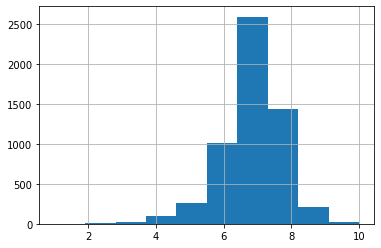

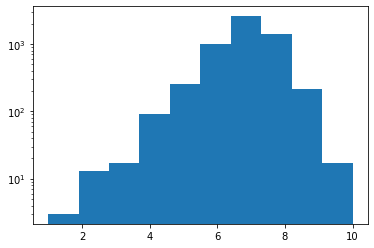

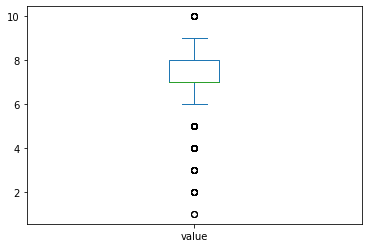

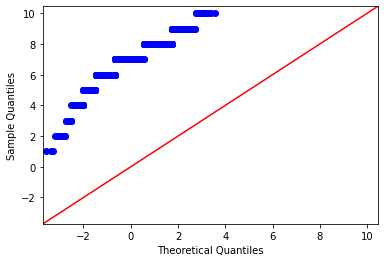

circumplex.arousal


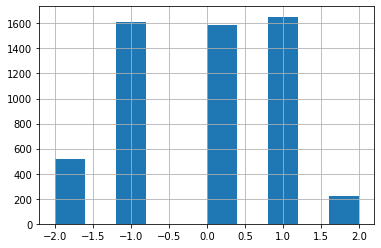

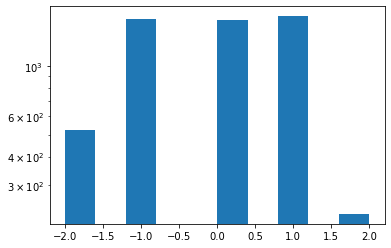

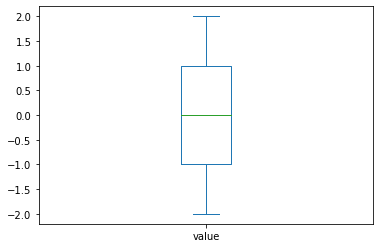

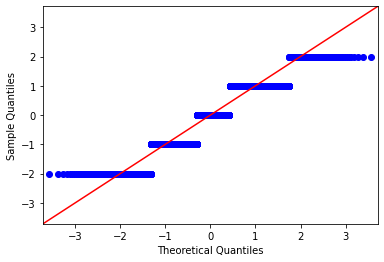

circumplex.valence


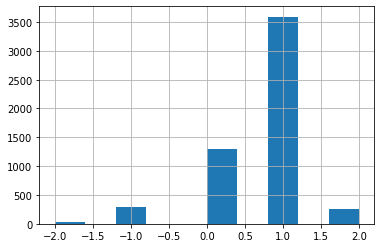

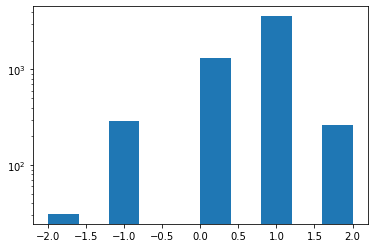

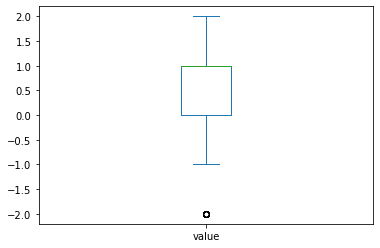

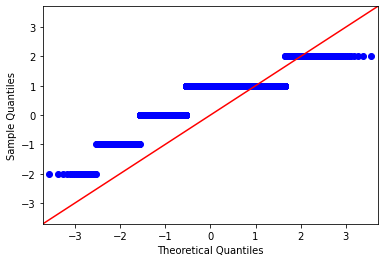

activity


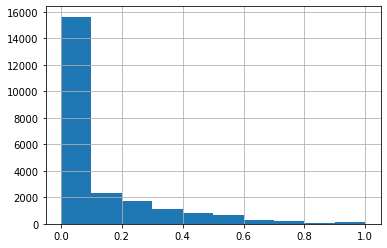

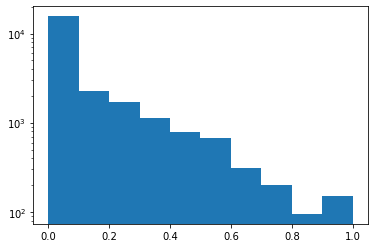

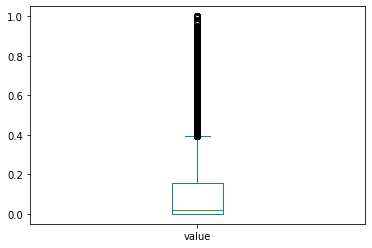

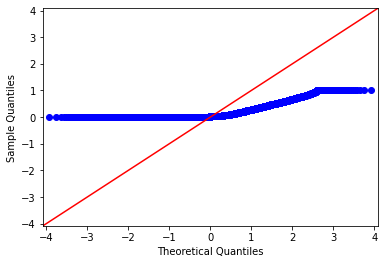

screen


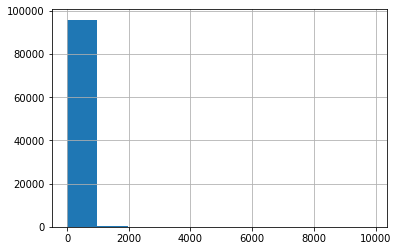

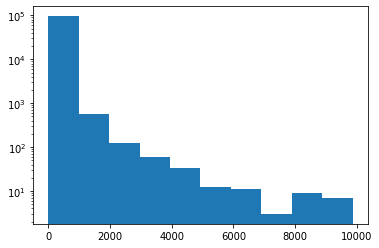

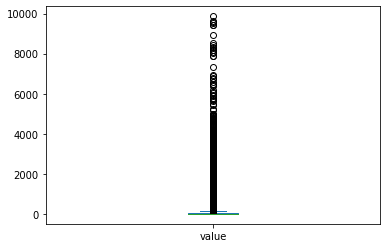

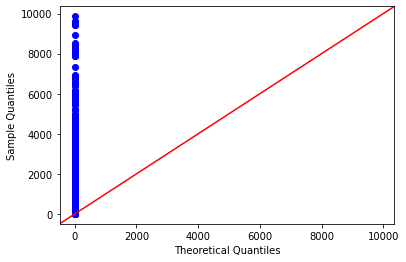

call


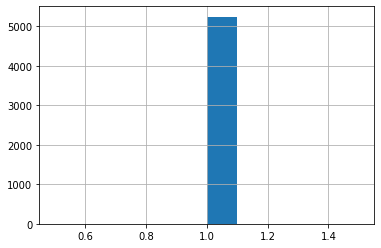

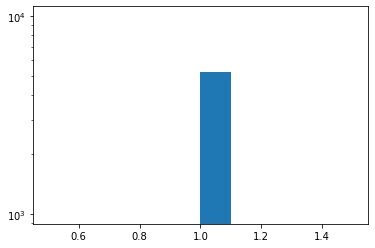

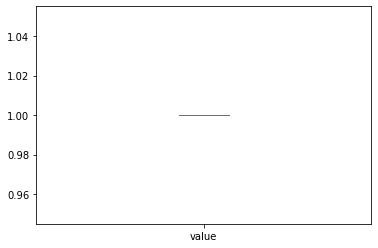

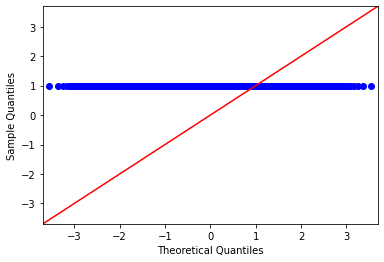

sms


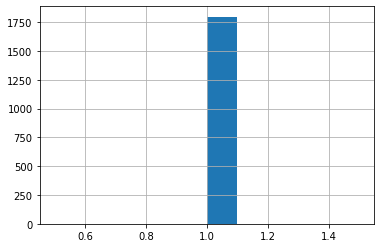

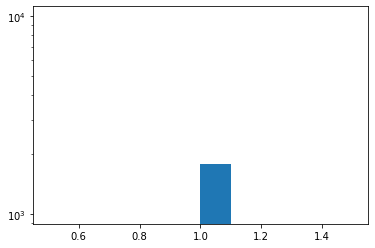

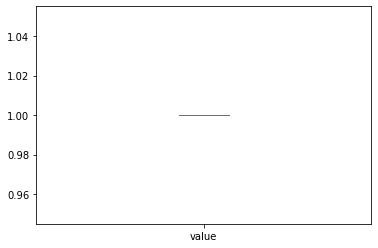

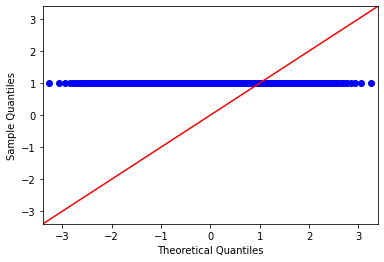

appCat.builtin


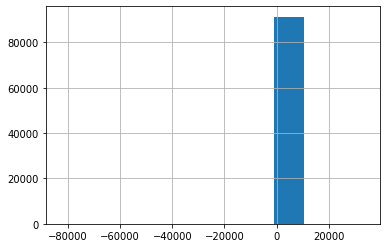

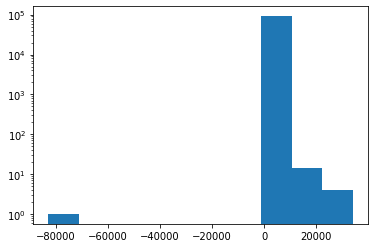

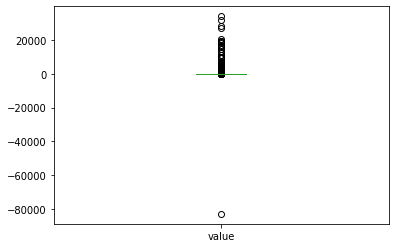

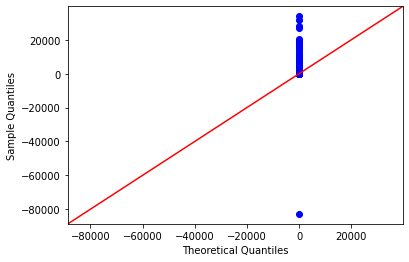

appCat.communication


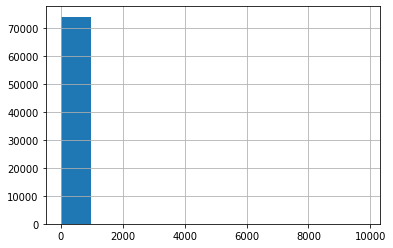

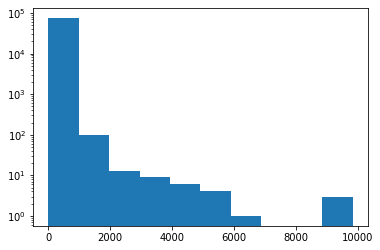

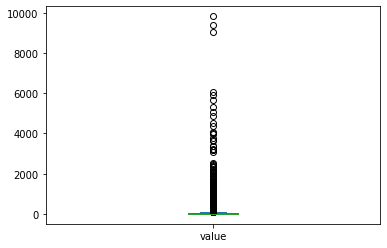

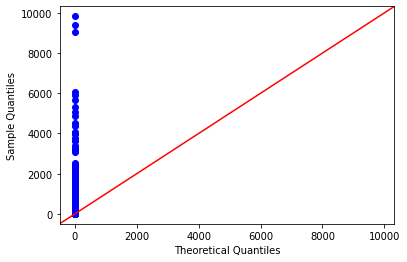

appCat.entertainment


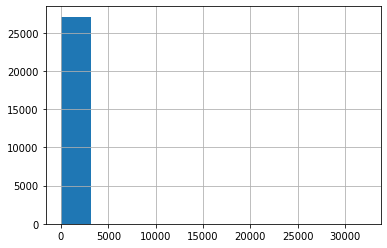

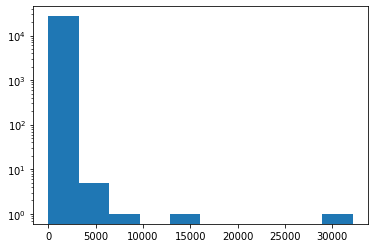

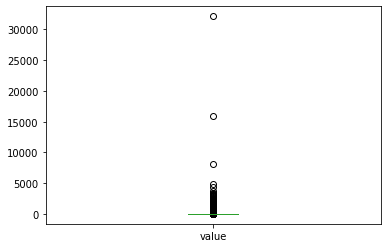

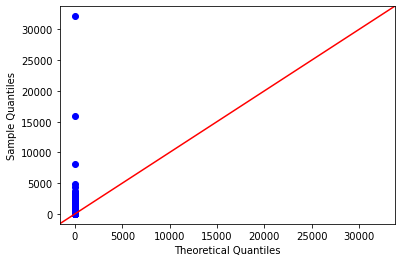

appCat.finance


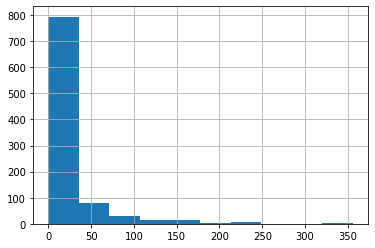

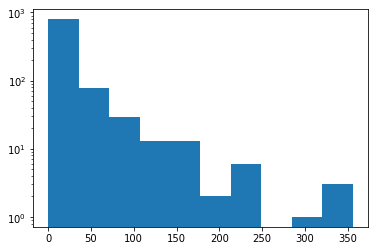

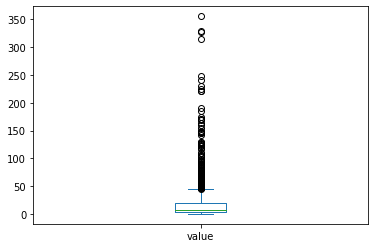

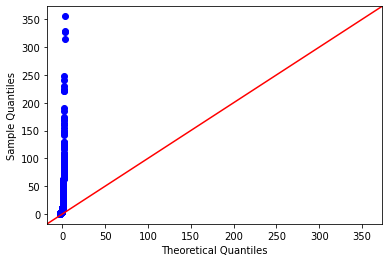

appCat.game


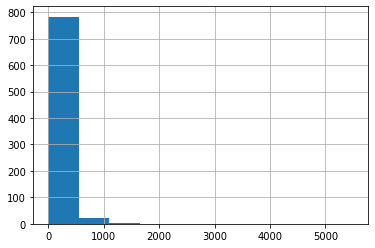

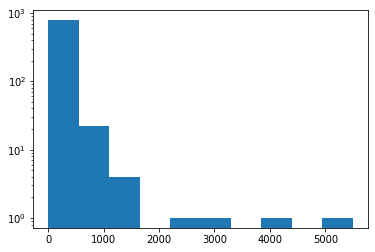

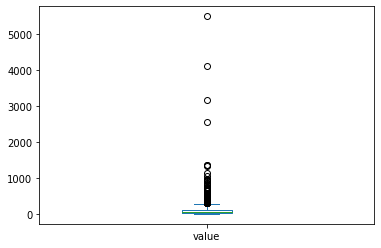

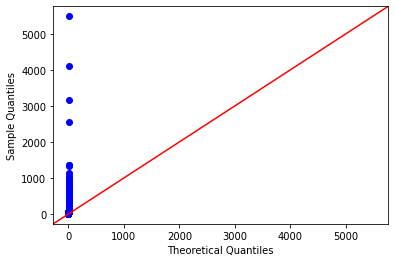

appCat.office


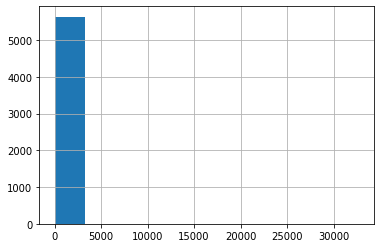

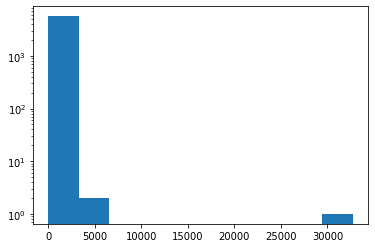

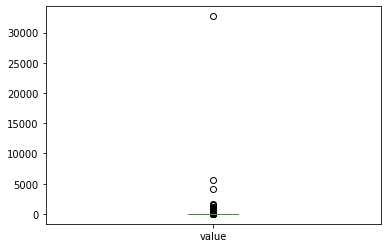

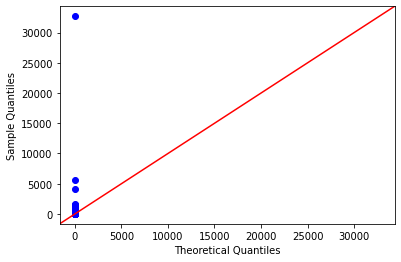

appCat.other


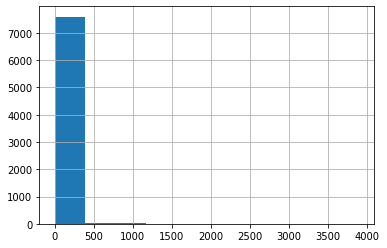

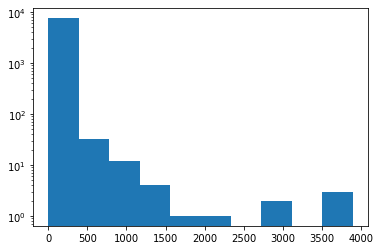

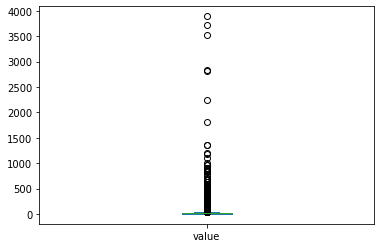

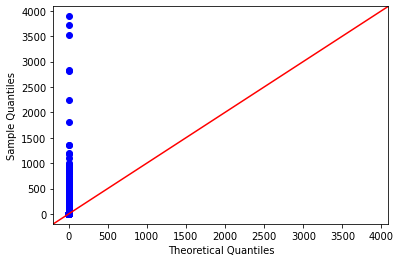

appCat.social


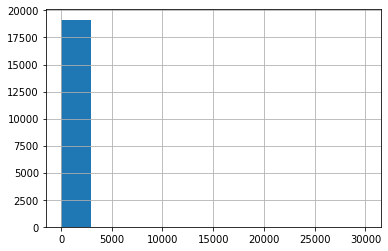

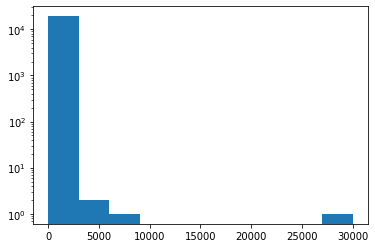

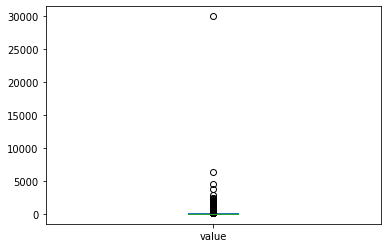

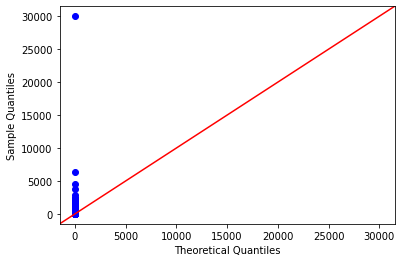

appCat.travel


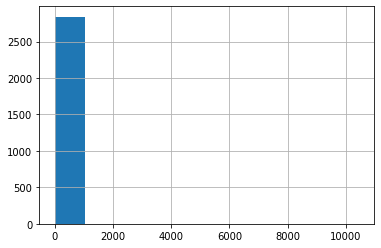

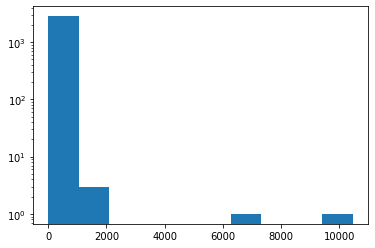

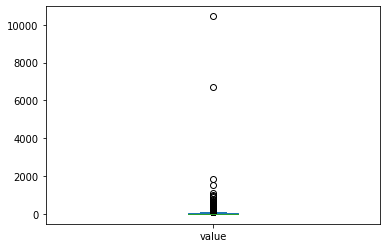

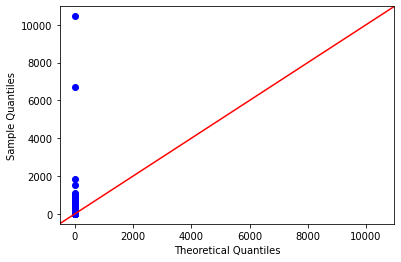

appCat.unknown


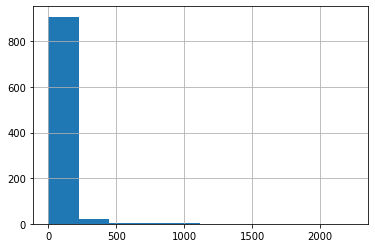

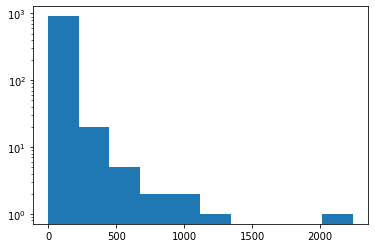

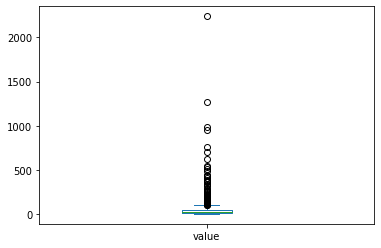

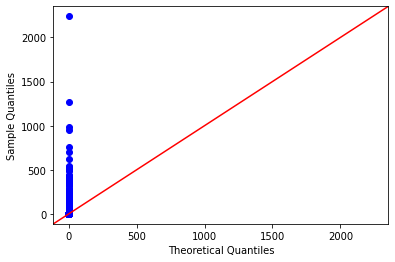

appCat.utilities


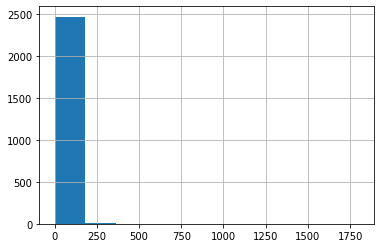

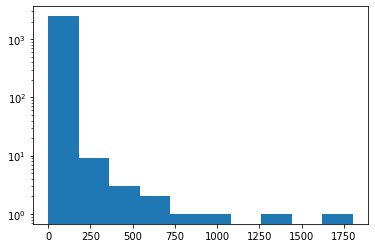

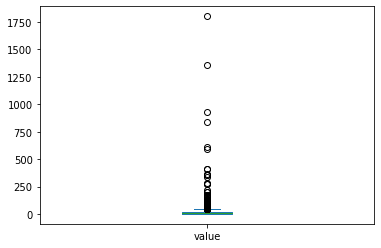

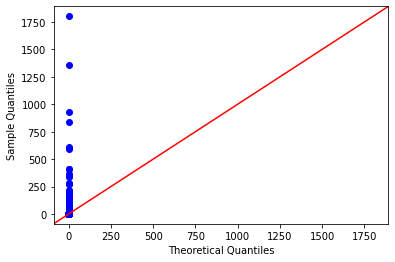

appCat.weather


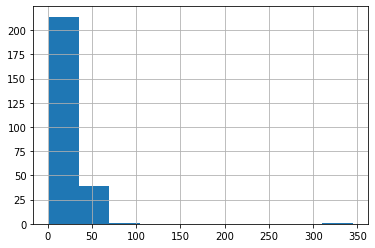

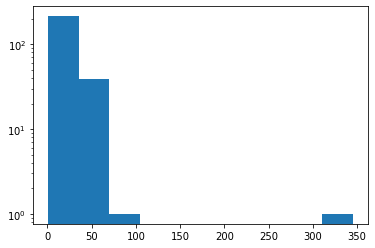

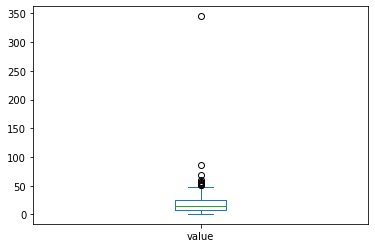

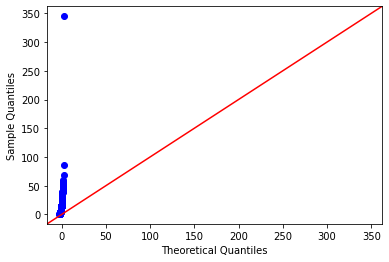

In [ ]:
codes, uniques = pd.factorize(mood.variable)

for item in uniques:
    print(item)
    c =mood.loc[mood['variable'] == str(item)]["value"]
    c.hist()
    plt.show()
    plt.hist(c, log=True)
    plt.show()
    c.plot.box()
    plt.show()
    sm.qqplot(c, line='45')
    pylab.show()

## 2. Data Proprocessing

In [ ]:
mood = mood.set_index([pd.Index(list(range(len(mood)))), 'id','time','variable'])
mood = mood.unstack('variable')

In [ ]:
mood.columns = [c[1] for c in mood.columns]
mood = mood.reset_index()
mood = mood.drop(columns = 'level_0')
mood

,id,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms
0,AS14.01,2014-02-26 13:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN
1,AS14.01,2014-02-26 15:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN
2,AS14.01,2014-02-26 18:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN
3,AS14.01,2014-02-26 21:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN
4,AS14.01,2014-02-27 09:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376699,AS14.30,2014-04-11 07:51:16.948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,8.032,NaN,NaN,NaN,NaN,NaN,NaN
376700,AS14.30,2014-04-19 11:00:32.747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.008,NaN,NaN,NaN,NaN,NaN,NaN
376701,AS14.30,2014-04-26 10:19:07.434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,7.026,NaN,NaN,NaN,NaN,NaN,NaN
376702,AS14.30,2014-04-27 00:44:48.450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,23.033,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
mood['time'] = pd.to_datetime(mood['time'])
mood

,id,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms
0,AS14.01,2014-02-26 13:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN
1,AS14.01,2014-02-26 15:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN
2,AS14.01,2014-02-26 18:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN
3,AS14.01,2014-02-26 21:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN
4,AS14.01,2014-02-27 09:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376699,AS14.30,2014-04-11 07:51:16.948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,8.032,NaN,NaN,NaN,NaN,NaN,NaN
376700,AS14.30,2014-04-19 11:00:32.747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.008,NaN,NaN,NaN,NaN,NaN,NaN
376701,AS14.30,2014-04-26 10:19:07.434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,7.026,NaN,NaN,NaN,NaN,NaN,NaN
376702,AS14.30,2014-04-27 00:44:48.450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,23.033,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# drop built in outlier
mood = mood.drop(mood.index[mood["appCat.builtin"].idxmin()])

In [ ]:
# create interaction -can be deleted, this will be done after filling in nas

# mood['valence*arousal'] = mood['circumplex.valence']*mood['circumplex.arousal']

In [ ]:
# seperate into evening and day
from datetime import datetime
evening_start = datetime.strptime('20:59', '%H:%M').time()

mood['screen_day'] = mood['screen'].loc[mood['time'].dt.time <= evening_start]
mood['screen_evening'] = mood['screen'].loc[mood['time'].dt.time > evening_start]
mood.loc[mood.screen_day > 1] # works but this guy always uses the phone at night
# we could also say we count anything between 9pm and 5am as night

,id,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms,screen_day,screen_evening
39693,AS14.01,2014-03-21 00:10:43.749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,11.963,NaN,11.963,NaN
39694,AS14.01,2014-03-21 02:12:22.811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,19.136,NaN,19.136,NaN
39695,AS14.01,2014-03-21 02:59:55.012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,15.218,NaN,15.218,NaN
39696,AS14.01,2014-03-21 03:12:27.441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,374.379,NaN,374.379,NaN
39697,AS14.01,2014-03-21 03:19:51.420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,9.126,NaN,9.126,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136245,AS14.33,2014-05-30 20:03:17.361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.008,NaN,5.008,NaN
136246,AS14.33,2014-05-30 20:05:37.832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,350.228,NaN,350.228,NaN
136247,AS14.33,2014-05-30 20:17:34.265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,61.683,NaN,61.683,NaN
136248,AS14.33,2014-05-30 20:45:55.023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.528,NaN,14.528,NaN


In [ ]:
ids = set(mood['id'])
people = [mood.loc[mood['id'] == id] for id in ids]
people[0]

,id,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms,screen_day,screen_evening
3646,AS14.24,2014-04-14 21:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN
3647,AS14.24,2014-04-15 09:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN
3648,AS14.24,2014-04-15 12:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN
3649,AS14.24,2014-04-15 15:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN
3650,AS14.24,2014-04-15 20:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375052,AS14.24,2014-06-03 09:38:09.551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
375053,AS14.24,2014-06-03 16:38:41.006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
375054,AS14.24,2014-06-03 16:38:43.482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
375055,AS14.24,2014-06-03 20:44:31.911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
all = ['id', 'time']

# changed activity

to_avg = ['mood', 'circumplex.valence', 'circumplex.arousal']
to_sum = ['appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.game', 'appCat.office', 
          'appCat.other', 'call', 'screen', 'sms', 'screen_evening', 'screen_day', 'activity']
to_count = ['appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.game', 'appCat.office', 
          'appCat.other', 'screen', 'screen_evening', 'screen_day', 'activity']


In [ ]:
people[0].sort_values(by='time')[-50:]

,id,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms,screen_day,screen_evening
287906,AS14.24,2014-06-07 23:25:42.203,NaN,NaN,35.370,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190938,AS14.24,2014-06-07 23:26:17.575,NaN,2.007,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
361263,AS14.24,2014-06-07 23:26:19.584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
361264,AS14.24,2014-06-07 23:27:25.243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104710,AS14.24,2014-06-07 23:27:25.250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,264.828,NaN,NaN,264.828
190939,AS14.24,2014-06-07 23:28:12.528,NaN,1.003,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
287907,AS14.24,2014-06-07 23:28:13.533,NaN,NaN,214.834,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190940,AS14.24,2014-06-07 23:31:48.368,NaN,1.686,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104711,AS14.24,2014-06-07 23:31:51.641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3304.955,NaN,NaN,3304.955
3882,AS14.24,2014-06-08 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN


In [ ]:
moods_day = [(person[all+to_avg].resample("D", on = 'time').mean().add_suffix('_avg'), 
              person[all + to_sum].resample("D", on = 'time').sum().add_suffix('_sum'),
              people[0][all + to_count].resample("D", on = 'time').count().drop(['time', 'id'], axis = 1).add_suffix('_count')
              ) for person in people]
moods_day = [pd.merge(x, pd.merge(y, z, on = 'time'), on = 'time') for x, y, z in moods_day]
moods_day[0]

,mood_avg,circumplex.valence_avg,circumplex.arousal_avg,appCat.builtin_sum,appCat.communication_sum,appCat.entertainment_sum,appCat.finance_sum,appCat.game_sum,appCat.office_sum,appCat.other_sum,...,appCat.communication_count,appCat.entertainment_count,appCat.finance_count,appCat.game_count,appCat.office_count,appCat.other_count,screen_count,screen_evening_count,screen_day_count,activity_count
time,,,,,,,,,,,,,,,,,,,,,
2014-04-09,NaN,NaN,NaN,0.000,0.000,0.0,0.0,0.0,0.0,0.000,...,0,0,0,0,0,0,0,0,0,0
2014-04-10,NaN,NaN,NaN,0.000,0.000,0.0,0.0,0.0,0.0,0.000,...,0,0,0,0,0,0,0,0,0,0
2014-04-11,NaN,NaN,NaN,0.000,0.000,0.0,0.0,0.0,0.0,0.000,...,0,0,0,0,0,0,0,0,0,0
2014-04-12,NaN,NaN,NaN,0.000,0.000,0.0,0.0,0.0,0.0,0.000,...,0,0,0,0,0,0,0,0,0,0
2014-04-13,NaN,NaN,NaN,0.000,0.000,0.0,0.0,0.0,0.0,0.000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-05,7.0,1.0,0.0,1749.277,958.821,0.0,0.0,0.0,0.0,47.360,...,37,0,0,0,0,5,59,4,55,24
2014-06-06,7.5,1.0,0.5,945.898,1710.924,0.0,0.0,0.0,0.0,36.414,...,44,0,0,0,0,4,57,4,53,24
2014-06-07,8.0,NaN,-1.0,5027.498,735.965,0.0,0.0,0.0,0.0,6.214,...,27,0,0,0,0,1,43,6,37,24


In [ ]:
for i in range(len(moods_day)):
  print(moods_day[i]['appCat.game_count'].value_counts())

0    62
Name: appCat.game_count, dtype: int64
0    37
Name: appCat.game_count, dtype: int64
0    37
Name: appCat.game_count, dtype: int64
0    36
Name: appCat.game_count, dtype: int64
0    27
Name: appCat.game_count, dtype: int64
0    27
Name: appCat.game_count, dtype: int64
0    52
Name: appCat.game_count, dtype: int64
0    27
Name: appCat.game_count, dtype: int64
0    27
Name: appCat.game_count, dtype: int64
0    27
Name: appCat.game_count, dtype: int64
0    30
Name: appCat.game_count, dtype: int64
0    17
Name: appCat.game_count, dtype: int64
0    39
Name: appCat.game_count, dtype: int64
0    27
Name: appCat.game_count, dtype: int64
0    30
Name: appCat.game_count, dtype: int64
0    27
Name: appCat.game_count, dtype: int64
0    30
Name: appCat.game_count, dtype: int64
0    30
Name: appCat.game_count, dtype: int64
0    27
Name: appCat.game_count, dtype: int64
0    26
Name: appCat.game_count, dtype: int64
0    27
Name: appCat.game_count, dtype: int64
0    27
Name: appCat.game_count, d

In [ ]:
from datetime import date, timedelta

for ind, person in enumerate(moods_day):
  d = person.loc[person['mood_avg'] >= 0].index
  print(f'Person {ind}')
  print(f'Number of days with mood measurement: {len(d)}')
  date_set = set(d[0] + timedelta(x) for x in range((d[-1] - d[0]).days))
  missing = sorted(date_set - set(d))
  print(f'Days which are missing in between: {missing}\n')

Person 0
Number of days with mood measurement: 55
Days which are missing in between: [Timestamp('2014-05-06 00:00:00')]

Person 1
Number of days with mood measurement: 36
Days which are missing in between: [Timestamp('2014-05-06 00:00:00')]

Person 2
Number of days with mood measurement: 35
Days which are missing in between: [Timestamp('2014-05-02 00:00:00'), Timestamp('2014-05-06 00:00:00')]

Person 3
Number of days with mood measurement: 29
Days which are missing in between: [Timestamp('2014-04-19 00:00:00'), Timestamp('2014-04-20 00:00:00'), Timestamp('2014-04-22 00:00:00'), Timestamp('2014-04-26 00:00:00'), Timestamp('2014-05-06 00:00:00')]

Person 4
Number of days with mood measurement: 24
Days which are missing in between: [Timestamp('2014-04-13 00:00:00'), Timestamp('2014-04-28 00:00:00'), Timestamp('2014-04-29 00:00:00')]

Person 5
Number of days with mood measurement: 27
Days which are missing in between: []

Person 6
Number of days with mood measurement: 51
Days which are mis

In [ ]:
# data set mit indizen der dates mit allen ausgefüllten daten einer Column 
def _list_dates(df, col):
    filled_dates = set(df.loc[df[col].notna()].index) # alle daten wo was drin ist
    all_dates = set(df[col].index)
    return sorted(filled_dates), sorted(all_dates) #geordnetes set als liste


# findet den anfang und das ende von den dates und dropt extreme
def _drop_extreme_values(filled_dates, all_dates, df):
    for idx, stamp in enumerate(all_dates):
        if stamp == filled_dates[0]:
            start = idx
        elif stamp == filled_dates[-1]:
            end = idx
    if filled_dates[-1] == all_dates[-1]:
        indexes = all_dates[start:]
    else:
        indexes = all_dates[start:end+1]
    return df[df.index.isin(indexes)]


# delete data with more than 4 nas => add to to drop list
def _del_data(df, col):
    to_drop = set()
    nas = list(df.loc[pd.isna(df[col]), :].index)
    for na in nas:
        if na + timedelta(days=3) in nas and na + timedelta(days=2) in nas and na + timedelta(days=1) in nas:
                to_drop.add(na)
                to_drop.add(na+ timedelta(days=1))
                to_drop.add(na+ timedelta(days=2))
                to_drop.add(na+ timedelta(days=3))

        elif na + timedelta(days=2) in nas and na + timedelta(days=2) in nas:
            to_drop.add(na)
            to_drop.add(na+ timedelta(days=1))
            to_drop.add(na+ timedelta(days=2))
            
    return df, sorted(to_drop)


# drop values from list          
def _drop_rows(df, lst):
    if len(lst) > 0:
        for row in reversed(lst):
            df = df.drop(row)
        return df
    return df


# get average of left ones 
def _get_avg(df, col):
    to_drop = []
    if df[col].isna().values.any():
        for stamp in list(df.loc[pd.isna(df[col]), :].index):
            if stamp + timedelta(days=1) in df.index:
                if df.loc[stamp + timedelta(days=1)][col] != np.nan:
                    day_before = df.loc[stamp - timedelta(days=1)][col]
                    day_after = df.loc[stamp + timedelta(days=1)][col]
                    day = (day_after + day_before)/2
                    df.loc[stamp, col] = day
            elif stamp + timedelta(days=1) in df.index:
                if df.loc[stamp + timedelta(days=2)][col] != np.nan:
                    day_before = df.loc[stamp - timedelta(days=1)][col]
                    day_after = df.loc[stamp + timedelta(days=2)][col]
                    day = (day_after + day_before)/2
                    df.loc[stamp, col] = day
            else:
                to_drop.append(stamp)
            
            
    return df, to_drop

def _two_dates(df):
    label = [df.index[i-1] + timedelta(days=1) == df.index[i] or df.index[i+1] - timedelta(days=1) == df.index[i] for i in range(len(df.index))]
    return df[label]

# splitted dfs falls sie nicht in einer Zeitreihe sind, löscht alle die weniger als 2 Reihen haben, da wir ansonsten nicht vorhersagen können was die Mood am 3. Tag ist

def data_frames(all_dfs):
    dfs = []
    #split = False
    idx = 0
    for df in all_dfs:
        idx += 1
        start = 0
        for i in range(len(df.index)-1):
            if df.index[i+1] != df.index[i] + timedelta(days=1):
                end =  i+1
                indexes = df.index[start:end]
                if len(df[df.index.isin(indexes)]) > 2:
                    dfs.append(df[df.index.isin(indexes)])
                start = i+1
                
        indexes =  df.index[start:]
        if len(df[df.index.isin(indexes)]) > 2:
                    dfs.append(df[df.index.isin(indexes)])

    
    return dfs

In [ ]:
# have to create new df because it doesnt change the df permantly in the functions
# application of the functions for mood_avg
new_dfs = []

for df in moods_day:
    filled_dates, all_dates = _list_dates(df, "mood_avg")
    df = _drop_extreme_values(filled_dates, all_dates, df)
    df, to_drop = _del_data(df, "mood_avg")
    df = _drop_rows(df, to_drop)
    df, to_drop = _get_avg(df, "mood_avg")
    df = _drop_rows(df, to_drop) 
    new_dfs.append(df)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [ ]:
# application of the functions for valence and arousal

new_dfs2 = []

for df in new_dfs:
    df, to_drop = _del_data(df, "circumplex.valence_avg")
    df = _drop_rows(df, to_drop)
    df, to_drop = _get_avg(df, "circumplex.valence_avg")
    df = _drop_rows(df, to_drop)

    df, to_drop = _del_data(df, "circumplex.arousal_avg")
    df = _drop_rows(df, to_drop)
    df, to_drop = _get_avg(df, "circumplex.arousal_avg")
    df = _drop_rows(df, to_drop)
    new_dfs2.append(df)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [ ]:
# checking if there is a df where there are not 2 days in a row (one was not => replaced)
another_df = []

def _two_dates(df):
    label = [df.index[i-1] + timedelta(days=1) == df.index[i] or df.index[i+1] - timedelta(days=1) == df.index[i] for i in range(len(df.index))]
    return df[label]
    
for df in new_dfs2:
    df = _two_dates(df)
    another_df.append(df)

In [ ]:
# replace all left nans with 0s

moods_nona = []

for df in another_df:
    df = df.fillna(0)
    moods_nona.append(df)

In [ ]:
moods_nona = data_frames(moods_nona)

In [ ]:
# update moods_day 
#moods_day = another_df
moods_day = moods_nona

Most have either 0 or only 1 day missing, so that should not be an issue and we should be able to interpolate the missing ones 

In [ ]:
moods_day[0].columns

Index(['mood_avg', 'circumplex.valence_avg', 'circumplex.arousal_avg',
       'appCat.builtin_sum', 'appCat.communication_sum',
       'appCat.entertainment_sum', 'appCat.finance_sum', 'appCat.game_sum',
       'appCat.office_sum', 'appCat.other_sum', 'call_sum', 'screen_sum',
       'sms_sum', 'screen_evening_sum', 'screen_day_sum', 'activity_sum',
       'appCat.builtin_count', 'appCat.communication_count',
       'appCat.entertainment_count', 'appCat.finance_count',
       'appCat.game_count', 'appCat.office_count', 'appCat.other_count',
       'screen_count', 'screen_evening_count', 'screen_day_count',
       'activity_count'],
      dtype='object')

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) a

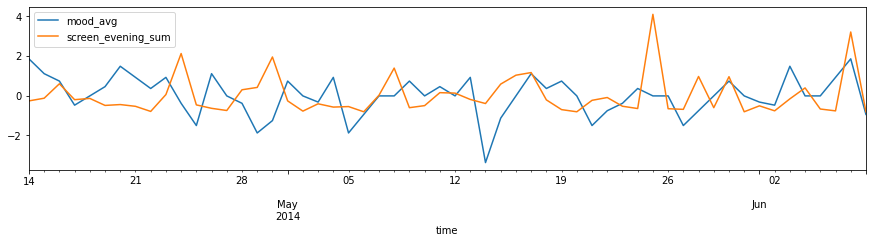

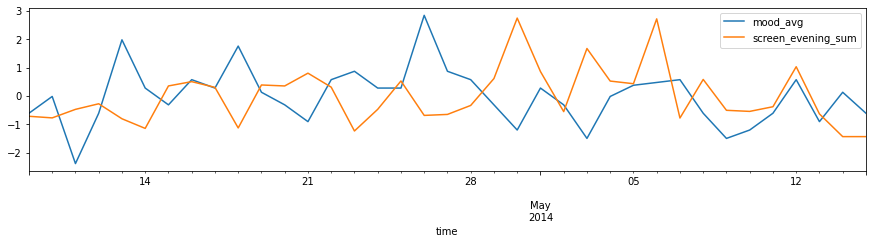

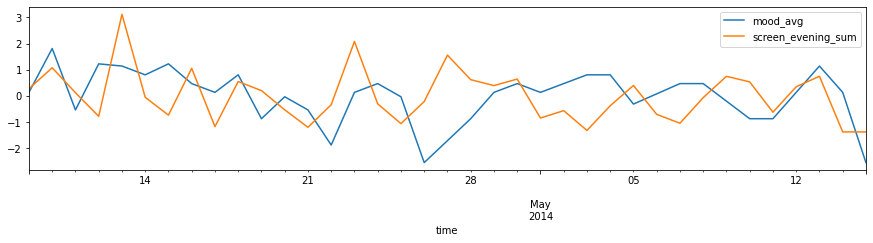

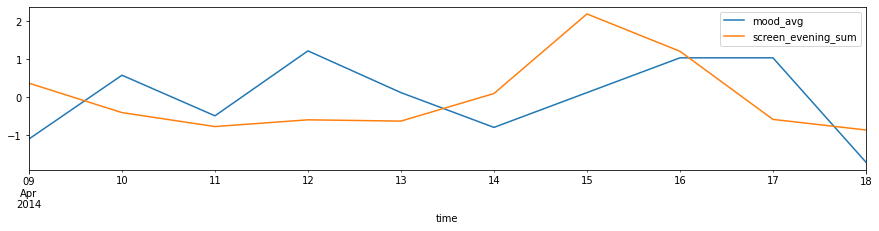

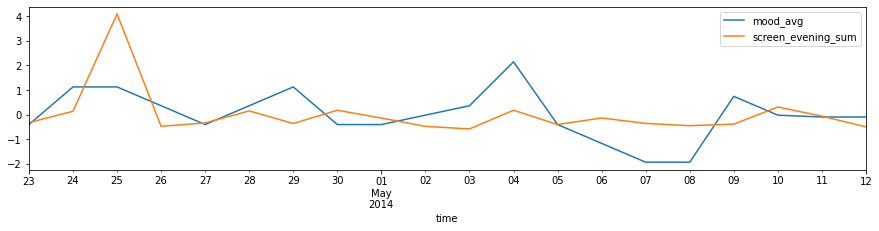

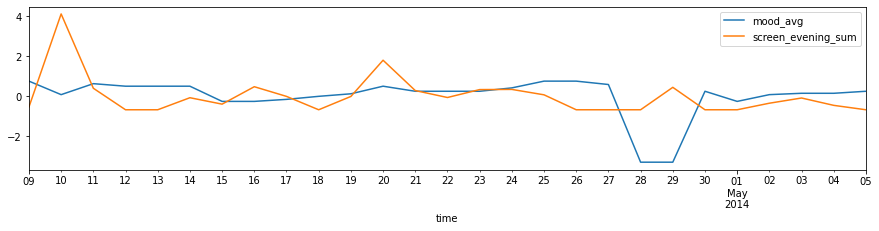

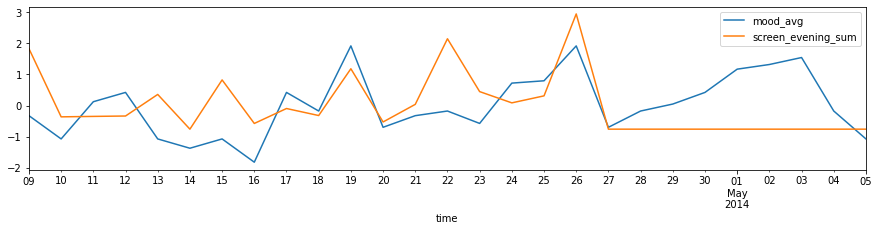

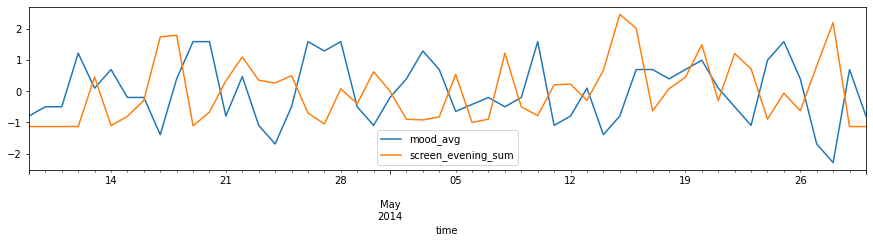

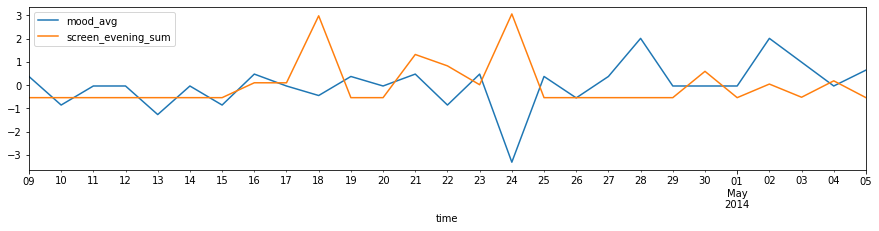

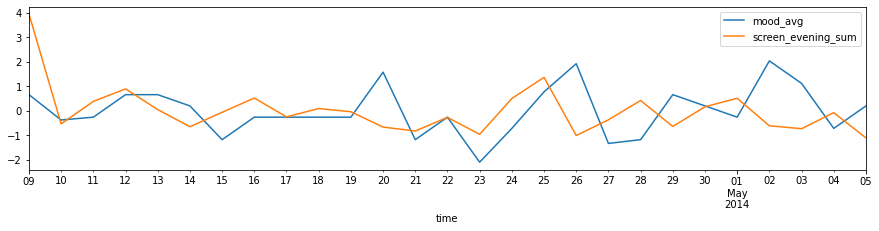

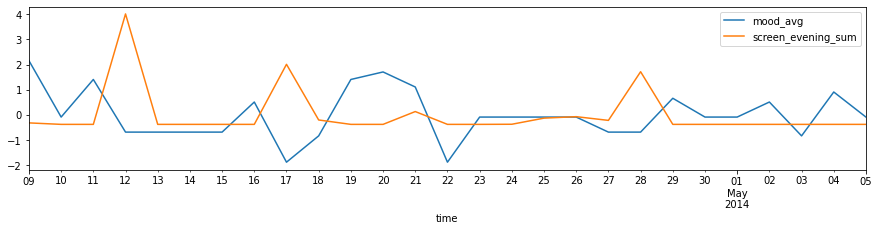

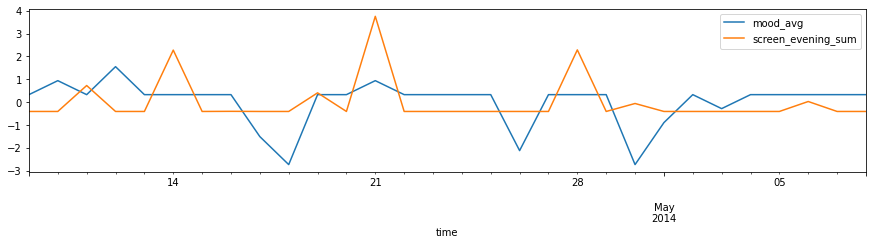

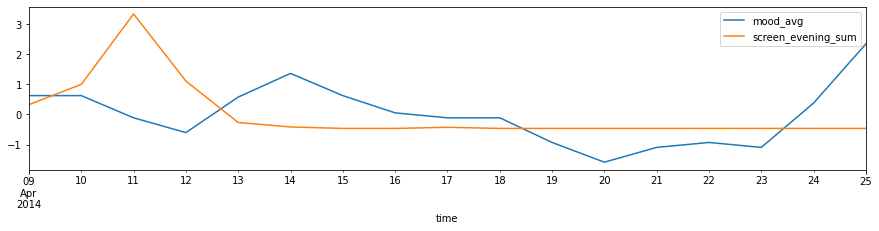

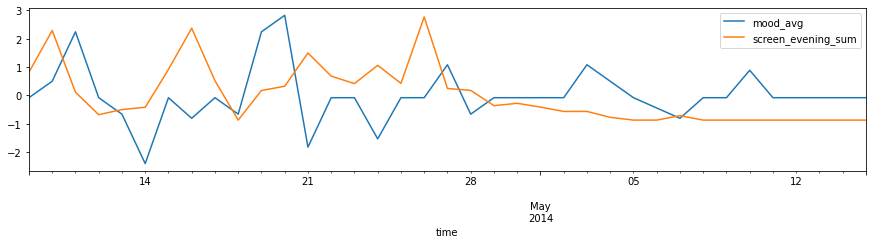

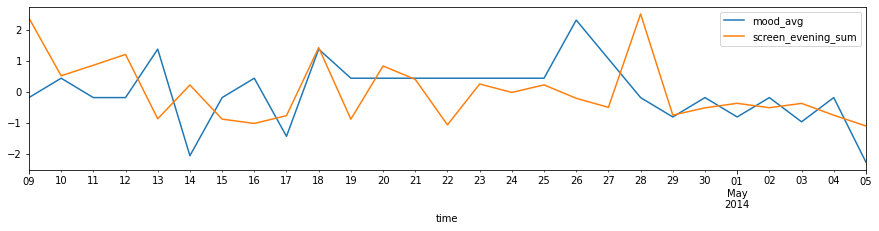

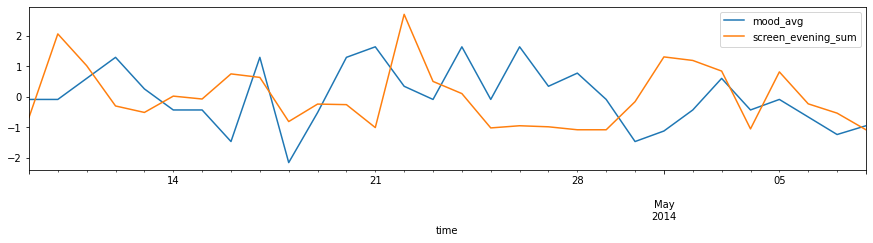

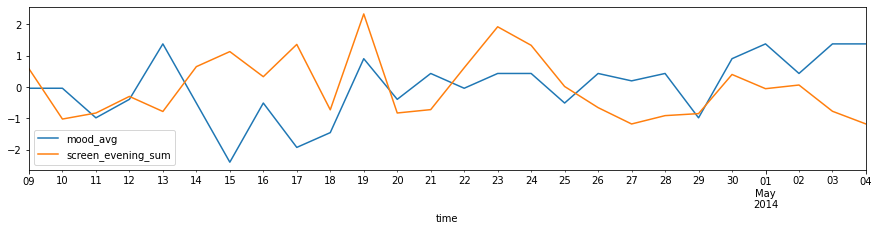

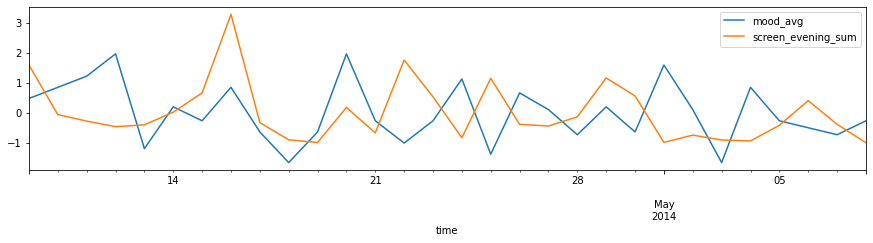

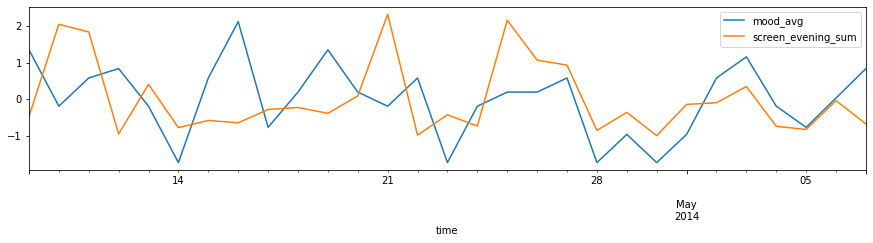

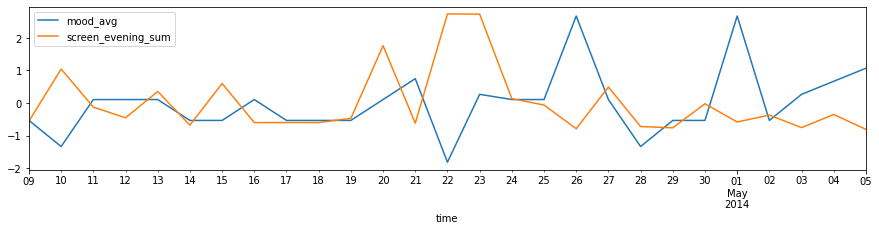

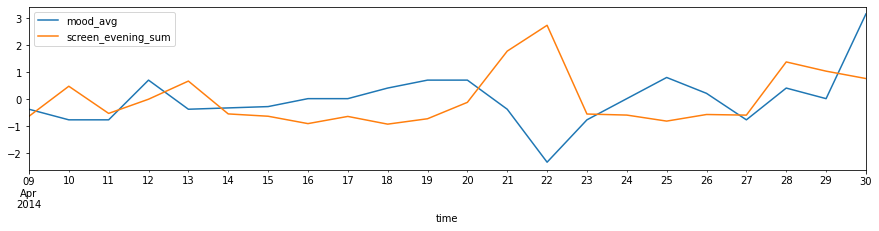

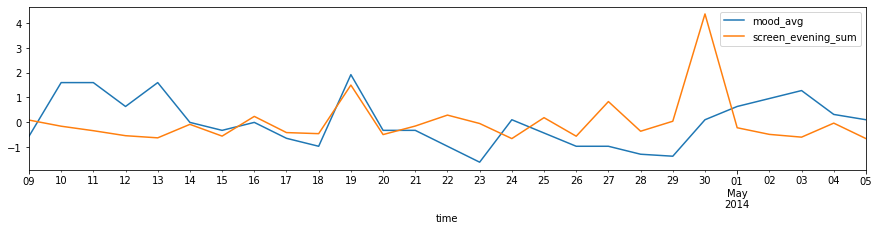

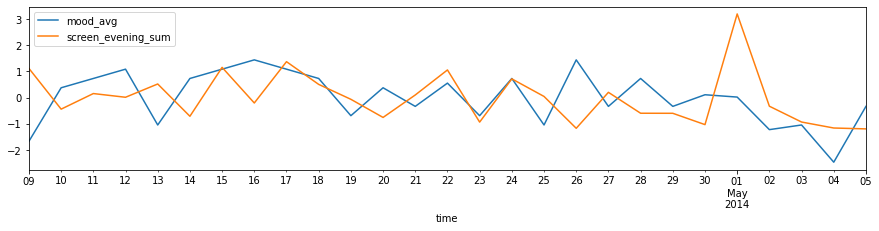

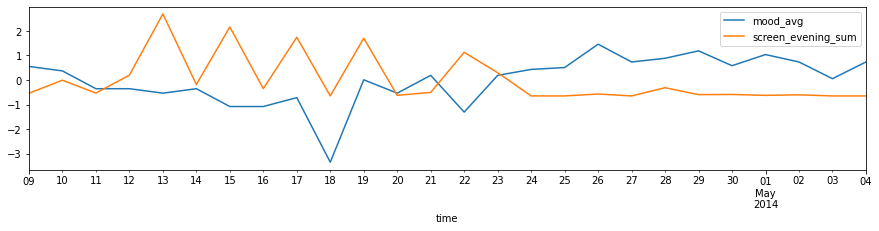

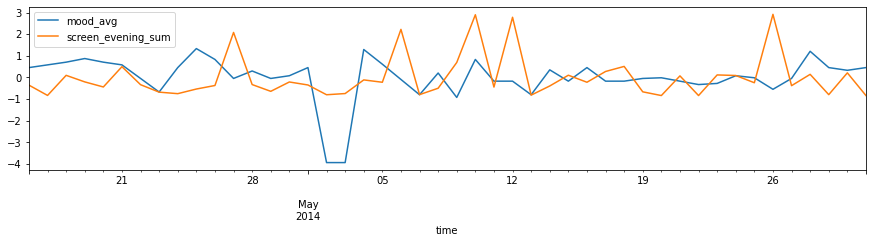

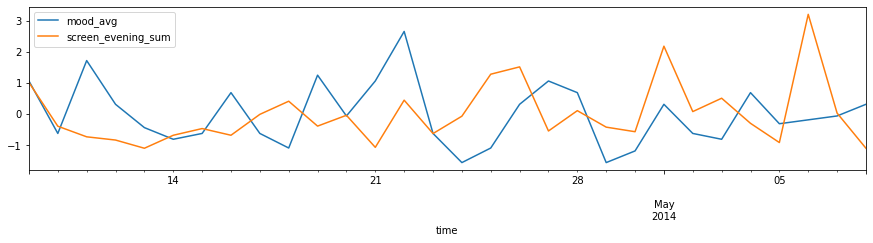

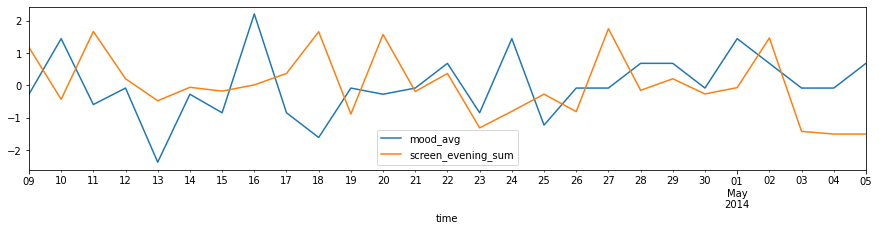

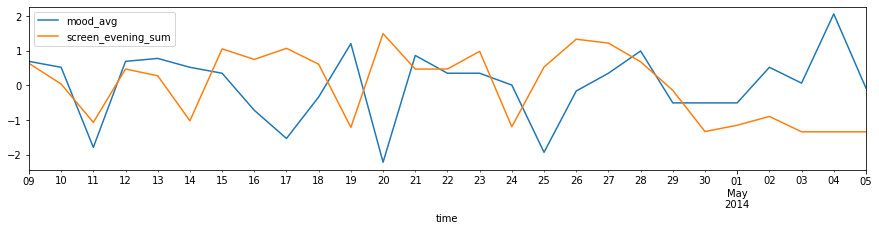

In [ ]:
for person in moods_day:
  person = (person-person.mean())/person.std()
  person[['mood_avg', 'screen_evening_sum']].plot(figsize=(15,3))

Yo I feel like with this plot now with some people you can clearly see how when the evening screen time goes up the mood goes down


I cant see a pattern lol but they are all kinda correlated I feel like

Oh and activity has a lot of values with sd > 3 so those might be outliers - or do you think they are valuable?

Plots for all people for all columns:

In [ ]:
# create interaction 
for mood in moods_day:
    mood['valence*arousal'] = mood['circumplex.valence_avg']*mood['circumplex.arousal_avg']
    
moods_day[1]

,mood_avg,circumplex.valence_avg,circumplex.arousal_avg,appCat.builtin_sum,appCat.communication_sum,appCat.entertainment_sum,appCat.finance_sum,appCat.game_sum,appCat.office_sum,appCat.other_sum,...,appCat.entertainment_count,appCat.finance_count,appCat.game_count,appCat.office_count,appCat.other_count,screen_count,screen_evening_count,screen_day_count,activity_count,valence*arousal
time,,,,,,,,,,,,,,,,,,,,,
2014-04-09,7.000000,0.800000,0.400000,773.605,2828.066,0.000,0.0,96.431,0.0,254.451,...,0,0,0,0,0,0,0,0,0,0.320000
2014-04-10,7.400000,0.400000,-0.200000,1097.353,1929.759,0.000,0.0,219.773,0.0,73.634,...,0,0,0,0,0,0,0,0,0,-0.080000
2014-04-11,5.800000,-0.600000,0.400000,683.657,712.525,0.000,0.0,114.861,0.0,46.374,...,0,0,0,0,0,0,0,0,0,-0.240000
2014-04-12,7.000000,0.500000,0.250000,2548.493,1614.301,0.000,0.0,148.916,0.0,47.090,...,0,0,0,0,0,0,0,0,0,0.125000
2014-04-13,8.750000,1.500000,0.500000,636.070,751.391,0.000,0.0,30.042,0.0,74.851,...,0,0,0,0,0,0,0,0,0,0.750000
2014-04-14,7.600000,0.800000,-0.800000,472.518,497.537,0.000,0.0,69.951,0.0,63.226,...,1,0,0,0,6,20,2,18,6,-0.640000
2014-04-15,7.200000,0.600000,-0.600000,746.260,2107.479,0.000,0.0,141.707,0.0,87.431,...,0,0,0,0,7,50,6,44,24,-0.360000
2014-04-16,7.800000,1.000000,-1.400000,927.055,2641.498,0.000,0.0,113.076,0.0,102.046,...,0,0,0,0,5,58,13,45,24,-1.400000
2014-04-17,7.600000,0.800000,0.200000,2018.145,1326.581,0.000,0.0,112.246,0.0,107.089,...,0,0,0,0,5,63,11,52,24,0.160000


# Random Forest

### data restructuring

In [ ]:
#This function prepares the data for model 2 (LSTM) but the function to prepare the data for model 1 (traditional algorithm) takes its result as input

#THIS FUNCTION IS TAKEN FROM THE WEBSITE I SENT TO YOU
# split a multivariate sequence into samples
def M2DataPrep(data, lag):
	data = np.array(data)
	X, y = list(), list()
	for i in range(len(data)):
		# find the end of this pattern
		train_y = i + lag
		# check if we are beyond the dataset
		if train_y > len(data)-1:
			break
		# gather input and output parts of the pattern
		xdata, ydata = data[i:train_y, :], data[train_y, :]
		X.append(xdata)
		y.append(ydata)
	return np.array(X), np.array(y)

In [ ]:
#This function prepares the data for the traditional algorithm and takes the previous function's output as its input, it then returns the data as a dataframe 
#(but we can change that if wanted, but I thought for the traditional algorithm it might be nice to have the data this way)

def M1DataPrep(xarr, yarr, cnames):
    x = xarr.mean(axis=1)
    y = yarr[ :,0]
    xframe = pd.DataFrame(data=x, columns=cnames)
    xframe.insert(loc=0, column="Target", value=y)

    return xframe

In [ ]:
moods_day[0].columns

Index(['mood_avg', 'circumplex.valence_avg', 'circumplex.arousal_avg',
       'appCat.builtin_sum', 'appCat.communication_sum',
       'appCat.entertainment_sum', 'appCat.finance_sum', 'appCat.game_sum',
       'appCat.office_sum', 'appCat.other_sum', 'call_sum', 'screen_sum',
       'sms_sum', 'screen_evening_sum', 'screen_day_sum', 'activity_sum',
       'appCat.builtin_count', 'appCat.communication_count',
       'appCat.entertainment_count', 'appCat.finance_count',
       'appCat.game_count', 'appCat.office_count', 'appCat.other_count',
       'screen_count', 'screen_evening_count', 'screen_day_count',
       'activity_count', 'valence*arousal'],
      dtype='object')

In [ ]:
len(moods_day[0].columns)

28

3avg + 13sum + 11count + 1interaction

In [ ]:
# Applying the above functions

data = pd.DataFrame()

for df in moods_day:
    df_x, df_y = M2DataPrep(data = df, lag = 2)
    c_names = ['mood_avg', 'circumplex.valence_avg', 'circumplex.arousal_avg',
       'activity_sum', 'appCat.builtin_sum', 'appCat.communication_sum',
       'appCat.entertainment_sum', 'appCat.finance_sum', 'appCat.game_sum',
       'appCat.office_sum', 'appCat.other_sum', 'call_sum', 'screen_sum',
       'sms_sum', 'screen_evening_sum', 'screen_day_sum',
       'appCat.builtin_count', 'appCat.communication_count',
       'appCat.entertainment_count', 'appCat.finance_count',
       'appCat.game_count', 'appCat.office_count', 'appCat.other_count',
       'screen_count', 'screen_evening_count', 'screen_day_count', 'activity_count', 'valence*arousal']
    df = M1DataPrep(df_x, df_y, c_names)
    data = data.append(df)
    
    

### Applying the random forest algorithm



In [ ]:
#Random Forest

#Advantages of random forest 
# --> every tree overfits a little, so forest as a whole is better at generalising
# --> work well without heavy tuning of parameters
# --> don't require scaling of the data

#Disadvantages of random forest
#---> doesn't work well on high dimensional, sparse data (e.g. text data)
#---> requires high memory
#---> slow

#Notes:
#---> Which variables do we want to stratify?
#---> max_features (size of feature subset selected for choosing the best test in each split) needs to be tuned (high means data is fit easily, low means distinct trees that need to be
# very deep in order to fit the data well) --> Rule of thumb for regression: max_features = log2(n_features)
# Other parameters possible to tune: 


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
import numpy as np

#Define features and target variable
X = data.iloc[:,1:]
y = data['Target']

#Split data in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#Set up grid search
param_grid = {"max_features": [round(np.log2(26), 0)-2, round(np.log2(26), 0), round(np.log2(26), 0)+2]}

#Build regressor
forest = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=-1, bootstrap=True) #n_estimators: should be as large as possible
#---> n_jobs=-1 means all cores of the computer are used, 
#---> Random state needs to be fixed for reproducible results (the more trees in the forest, the less dependable we are on a random state)

forest.fit(X_train, y_train) #Fit the forest
print("Test-set R^2 {:.2f}".format(forest.score(X_test, y_test))) #Test on test set

y_pred = forest.predict(X_test)
y_pred_train = forest.predict(X_train)

Test-set R^2 0.07


In [ ]:
## Grid search 

from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
max_features = round(np.log2(len(X_train.columns)))

param_grid = {
    'bootstrap': [True],
    'max_depth': [110, 120, 130],
    'max_features': [max_features+1, max_features+2, max_features+3]}
 #   'min_samples_leaf': [3, 4, 5],
 #   'min_samples_split': [9, 10, 11],
 #   'n_estimators': [80, 90, 100, 150]
#}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = forest, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=0),
             n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [110, 120, 130],
                         'max_features': [6, 7, 8]},
             verbose=2)

In [ ]:
grid_search.best_params_ # 
# {'bootstrap': True,
#  'max_depth': 110,
#  'max_features': 6,
#  'min_samples_leaf': 4,
#  'min_samples_split': 10,
#  'n_estimators': 100}
grid_search.best_score_ # 0.20150901158253495
grid_search.best_estimator_

RandomForestRegressor(max_depth=120, max_features=8, n_jobs=-1, random_state=0)

In [ ]:
## applying the best solution to the model 

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
import numpy as np

#Define features and target variable
X = data.iloc[:,1:]
y = data['Target']

#Split data in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#Set up grid search
param_grid = {"max_features": [round(np.log2(26), 0)-2, round(np.log2(26), 0), round(np.log2(26), 0)+2]}

#Build regressor
forest = RandomForestRegressor(n_estimators=1000, random_state=0, n_jobs=-1, bootstrap=True) #n_estimators: should be as large as possible
#---> n_jobs=-1 means all cores of the computer are used, 
#---> Random state needs to be fixed for reproducible results (the more trees in the forest, the less dependable we are on a random state)

forest.fit(X_train, y_train) #Fit the forest
print("Test-set R^2 {:.2f}".format(forest.score(X_test, y_test))) #Test on test set

y_pred = forest.predict(X_test)
y_pred_train = forest.predict(X_train)

Test-set R^2 0.12


In [ ]:
# model predictions 


# Use the forest's predict method on the test data
predictions = forest.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# # Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


Mean Absolute Error: 0.57 degrees.


In [ ]:
# all results of the model

from sklearn import metrics

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_test, y_pred, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('Explained Variance Score:', metrics.explained_variance_score(y_test, y_pred))
print('Max Error:', metrics.max_error(y_test, y_pred))
print('Mean Squared Log Error:', metrics.mean_squared_log_error(y_test, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_test, y_pred))
print('R^2:', metrics.r2_score(y_test, y_pred))
print('Mean Poisson Deviance:', metrics.mean_poisson_deviance(y_test, y_pred))


Mean Absolute Error (MAE): 0.570568298969073
Mean Squared Error (MSE): 0.6911377556099667
Root Mean Squared Error (RMSE): 0.8313469526076142
Mean Absolute Percentage Error (MAPE): 139819357606552.31
Explained Variance Score: 0.1452657605427976
Max Error: 6.022950000000002
Mean Squared Log Error: 0.0279363276089313
Median Absolute Error: 0.4162625000000153
R^2: 0.11608118100394327
Mean Poisson Deviance: 0.13712310265069105


In [ ]:
mses = []
r2s = []

for i in range(10000):
    ypred, ytrue = resample(y_pred, y_test, n_samples = len(y_pred))
    mses.append(metrics.mean_squared_error(ytrue, ypred))
    r2s.append(metrics.r2_score(ytrue, ypred))
    
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(np.array(mses), p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(np.array(mses), p)

mse = metrics.mean_squared_error(y_test, y_pred)
print('Mean Squared Error (MSE):', mse)
print(f'95% MSE confidence interval between {lower} and {upper}')

p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(np.array(r2s), p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(np.array(r2s), p))

r2 = metrics.r2_score(y_test, y_pred)
print('R^2:', r2)
print(f'95% R2 confidence interval between {lower} and {upper}')

Mean Squared Error (MSE): 0.6911377556099667
95% MSE confidence interval between 0.42359236339478634 and 1.1422724386018484
R^2: 0.11608118100394327
95% R2 confidence interval between 0.0 and 0.23765856137292735


In [ ]:
ses_rf = 

SyntaxError: ignored

In [ ]:
# nice plot part 1

import time
import numpy as np

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

In [ ]:
# nice plot part 2

import pandas as pd

feature_names = X_train.columns

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# PCA - Feature reduction

In [ ]:
# appending the data off all people together 
# because if we train one model for all people we also need to have one PCA for all
# so that the components represent the same for all perticipants

mood_day = moods_day[0]
mood_day = mood_day.assign(participant='1')
for index, person in enumerate(moods_day):
    person = person.assign(participant=str(index+2))
    mood_day = mood_day.append(person)

mood_day

In [ ]:
to_pca = ['circumplex.valence_avg', 'circumplex.arousal_avg',
       'appCat.builtin_sum', 'appCat.communication_sum',
       'appCat.entertainment_sum', 'appCat.finance_sum', 'appCat.game_sum',
       'appCat.office_sum', 'appCat.other_sum', 'call_sum', 'screen_sum',
       'sms_sum', 'screen_evening_sum', 'screen_day_sum', 'activity_sum',
       'appCat.builtin_count', 'appCat.communication_count',
       'appCat.entertainment_count', 
       'appCat.other_count',
       'screen_count', 'screen_evening_count', 'screen_day_count',
       'activity_count', 'valence*arousal']

# removed , 'appCat.office_count', 'appCat.game_count', 'appCat.finance_count', because it was always 0
# TODO: figure out why office count was always 0  

In [ ]:
# normalize input for PCA

mood_day_n = mood_day.copy()

for column in to_pca:
    mood_day_n[column] = (mood_day[column] - mood_day[column].min())/(mood_day[column].max() - mood_day[column].min())
mood_day_n

In [ ]:
#! pip install factor_analyzer # run this first to install it
from factor_analyzer import FactorAnalyzer

In [ ]:
mood_day["appCat.game_count"].value_counts()

In [ ]:
for var in to_pca:
  print(var)
  print(mood_day[var].mean())

In [ ]:
# this will only run once we have dealt with missing values 
fa = FactorAnalyzer(method='principal', rotation="varimax")
fa.fit(mood_day[to_pca])

ev, v = fa.get_eigenvalues()

#plt.scatter(range(1,mood_day_n.shape[1]+1),ev)
plt.plot(range(1,mood_day[to_pca].shape[1]+1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [ ]:
n_features = 10 # we have to decide on this based on the plot
fa = FactorAnalyzer(n_factors=n_features, method='principal', rotation="varimax")
fa.fit(mood_day[to_pca])
factor_matrix = fa.loadings_ # a two dimensional array of shape [n_rows, n_features]

factor_matrix

In [ ]:
fa.get_factor_variance()

In [ ]:
features_reduced = np.array(mood_day[to_pca]).dot(factor_matrix)
len(features_reduced)

In [ ]:
features_final = np.empty((len(features_reduced), n_features+1))

for i in range(len(features_reduced)):
    features_final[i] = np.append(features_reduced[i], mood_day['mood_avg'][i])
    
features_final[0]

In [ ]:
#features_normed = (features_final -  features_final.min(axis=0))/ (features_final.max(axis=0) - features_final.min(axis=0))
features_normed = features_final

features_normed[0]

In [ ]:
features_normed.shape

In [ ]:
mood_pca = pd.DataFrame({'participant': mood_day['participant'], 'mood': mood_day['mood_avg'], 'features': features_normed.tolist()})

moods_pca = []
for i in range(1, 29):
    person = mood_pca.loc[mood_pca['participant'] == str(i)]
    moods_pca.append(person)

moods_pca[0]

## Plots

In [ ]:
for person in people:
    for item in uniques:
        print(person.iloc[0,0])
        print(item)
        c =person[str(item)]
        c.hist()
        plt.show()
        c.plot.box()
        plt.show()
        #sm.qqplot(c, line='45')
        #pylab.show()
        

## ARIMA approach (very basic) - values at the moment very bad

In [ ]:
plot_acf(mood.mood)

In [ ]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(mood.mood.diff())

ax2 = f.add_subplot(122)
plot_acf(mood.mood.diff().dropna(), ax=ax2)
plt. show()

In [ ]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('2nd Order Differencing')
ax1.plot(mood.mood.diff().diff())

ax2 = f.add_subplot(122)
plot_acf(mood.mood.diff().diff().dropna(), ax=ax2)
plt. show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(mood.mood.dropna())
print(f"p-value: {result[1]}")

result = adfuller(mood.mood.diff().dropna())
print(f"p-value: {result[1]}")

result = adfuller(mood.mood.diff().diff().dropna())
print(f"p-value: {result[1]}")


# all significant => thats good; can take the first one; so d is 1 or 0?


In [ ]:
We have to chose parameters d,p and

d = either 0 or 1 based on the ADF test above
p = 1 since the first one is most crucial one in the plots
q = 2 because two are crossing the threshold?

In [ ]:
import statsmodels

test = round(len(mood.mood)*0.1)
train = len(mood.mood) - test

arima_model = statsmodels.tsa.arima.model.ARIMA(mood.mood[:train], order=(0,1,2))
model = arima_model.fit()
print(model.summary())

# says SARIMAX now

In [ ]:
model.plot_diagnostics()
plt.show()

In [ ]:
y_pred = pd.Series(data=model.forecast(test), index=mood.mood[train:].index)
y_true = mood.mood[train:]

print(np.array(y_pred).astype(np.uint8))
print(np.array(y_true))

In [ ]:
y_pred=pd.Series(model.forecast(test),index=mood.mood[train:].index)
y_true = mood.mood[train:]
mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true)) # Mean absolute percentage error
mae = np.mean(np.abs(y_pred - y_true))
#Mean absolute error
mpe = np.mean((y_pred - y_true)/y_true)
#Mean percentage error
rmse = np.mean((y_pred - y_true)**2)**.5
# RMSE
corr = np. corrcoef(y_pred, y_true)[0,1]
#Correlation Coefficient
mins = np.amin(np.hstack([y_pred[:,None], y_true[:,None]]), axis=1)
maxs = np.amax(np.hstack([y_pred[:,None], y_true[:,None]]), axis=1)
minmax = 1 - np.mean(mins/maxs)
# minmax

import pprint
pprint.pprint({"mape":mape,
    "mae": mae,

    "mpe": mpe,
    "pmse":rmse,

    "corr" :corr,
    "minmax":minmax})


In [ ]:
n = np.array(mood[:train]).shape[0]
d = np.abs(np.diff(np.array(mood[:train].mood))).sum()/(n-1)
errors = np.abs(y_true- y_pred)
print(errors.mean()/d)

#Autocorrelation

In [ ]:
#Autocorrelation

from statsmodels.tsa.stattools import acf
from pandas.plotting import autocorrelation_plot

autocorrs = []

for userdata in moods_day:
    umood = userdata.mood_avg
    #print(umood)
    ucorr = umood.autocorr(lag=7)
    autocorrs.append(ucorr)
    #autocorrelation_plot(umood)

    #ufunc = acf(umood)
    #plt.plot(ufunc)
    #plt.show()
print(sum(autocorrs)/len(autocorrs))
#print(autocorrs)

#Data Restructuring

In [ ]:
#This function prepares the data for model 2 (LSTM) but the function to prepare the data for model 1 (traditional algorithm) takes its result as input


#THIS FUNCTION IS TAKEN FROM THE WEBSITE I SENT TO YOU
# split a multivariate sequence into samples
def M2DataPrep(data, lag):
	X, y = list(), list()
	for i in range(len(data)):
		# find the end of this pattern
		train_y = i + lag
		# check if we are beyond the dataset
		if train_y > len(data)-1:
			break
		# gather input and output parts of the pattern
		xdata, ydata = data[i:train_y, :], data[train_y, :]
		X.append(xdata)
		y.append(ydata)
	return array(X), array(y)

In [ ]:
#This function prepares the data for the traditional algorithm and takes the previous function's output as its input, it then returns the data as a dataframe 
#(but we can change that if wanted, but I thought for the traditional algorithm it might be nice to have the data this way)

def M1DataPrep(xarr, yarr, cnames):
    x = xarr.mean(axis=1)
    y = yarr[ :,0]
    xframe = pd.DataFrame(data=x, columns=cnames)
    xframe.insert(loc=0, column="Target", value=y)

    return xframe

# Data prep

In [ ]:
def in_out(x, y, lag):
    x = np.array(x)
    y = np.array(y)
    X, Y = list(), list()
    for i in range(len(x)):
        # find the end of this pattern
        train_y = i + lag
        # check if we are beyond the dataset
        if train_y > len(x)-1:
            break
        # gather input and output parts of the pattern
        xdata, ydata = x[i:train_y], y[train_y]
        X.append(xdata)
        Y.append(ydata)
    return np.array(X), np.array(Y)

allx, ally = [], []

for person in moods_pca: 
    x, y = in_out(person['features'], person['mood'], 2)
    for el in x:
        allx.append(np.array([np.array(e) for e in el]))
    for em in y:
        ally.append(em)

print(allx[0])

print(ally[0])

## seperate into training and test

In [ ]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(allx, ally, test_size = 0.25, random_state = 42)

import tensorflow as tf 

xtrain = tf.convert_to_tensor(xtrain)
ytrain = tf.convert_to_tensor(ytrain)
xtest = tf.convert_to_tensor(xtest)
ytest = tf.convert_to_tensor(ytest)

## Baselines

In [ ]:
xbaseline = [inp[1][n_features] for inp in xtest]
xbaseline

from sklearn import metrics 


print('Mean Squared Error (MSE):', metrics.mean_squared_error(ytest, xbaseline))
print('R^2:', metrics.r2_score(ytest, xbaseline))

In [ ]:
xbaseline = np.array(xbaseline)
ytest = np.array(ytest)

mses = []
r2s = []

for i in range(10000):
    ypred, ytrue = resample(xbaseline, ytest, n_samples = len(y_pred_true))
    mses.append(metrics.mean_squared_error(ytrue, ypred))
    r2s.append(metrics.r2_score(ytrue, ypred))
    
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = np.percentile(np.array(mses), p)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(np.array(mses), p)

mse = metrics.mean_squared_error(ytest, xbaseline)
print('Mean Squared Error (MSE):', mse)
print(f'95% MSE confidence interval between {lower} and {upper}')

p = ((1.0-alpha)/2.0) * 100
lower = np.percentile(np.array(r2s), p)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(np.array(r2s), p)

r2 = metrics.r2_score(ytest, xbaseline)
print('R^2:', r2)
print(f'95% R2 confidence interval between {lower} and {upper}')

Mean Squared Error (MSE): 0.47744123931623933 R^2: 0.06151083779008115


# LSTM

In [ ]:
# ! pip install keras
# ! pip install tensorflow

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

from keras.callbacks import History 

## Grid Search

In [ ]:
def lstm(learning_rate, layer_size, xtrain, xtest, ytrain, ytest):  

    history = History()

    n_steps = 2
    n_feat = n_features +1
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    epochs = 500

    model = Sequential()
    model.add(LSTM(layer_size, activation='relu', return_sequences=True, input_shape=(n_steps, n_feat)))
    model.add(LSTM(layer_size, activation='tanh'))
    model.add(Dense(2))
    # model.add(tf.keras.layers.Softmax())
    model.add(Activation("softmax"))
    model.compile(optimizer=optimizer, loss='mse')
        
    model.fit(xtrain, ytrain, epochs= epochs, verbose=0, validation_split = 0.1, callbacks=[history], workers = 7, use_multiprocessing = True)

    y_pred = model.predict(xtest, verbose=1)
    y_pred_good = [y[1] for y in y_pred]
    ytest_good = [y[1] for y in ytest]
    

    return metrics.r2_score(ytest_good, y_pred_good), history.history['val_loss']

In [ ]:
ytrain_good = np.array(ytrain)/10
ytrain_class = np.zeros((len(ytrain_good), 2))
for i in range(len(ytrain_good)):
    ytrain_class[i] = np.array([1-ytrain_good[i], ytrain_good[i]])

In [ ]:
lrs = []
lss = []
r2s = []
hists = []


for lr in [0.0005, 0.0001, 0.00005]:
    for layer_size in [50, 100, 150]:
        for i in range(3):
            xtrains, xtests, ytrains, ytests = train_test_split(xtrain, ytrain_class, test_size = 0.2, random_state = i)
            
            
            xtrains = tf.convert_to_tensor(xtrains)
            ytrains = tf.convert_to_tensor(ytrains)
            xtests = tf.convert_to_tensor(xtests)
            ytests = tf.convert_to_tensor(ytests)
            
            r2s5 = []
            hists5 = []

            r2, hist = lstm(lr, layer_size, xtrains, xtests, ytrains, ytests)
            r2s5.append(r2)
            hists5.append(hist)
            
        lrs.append(lr)
        lss.append(layer_size)
        r2s.append(np.mean(np.array(r2s5)))
        hists.append(hists5)
        print()
        print(layer_size)
        print(lr)
        print('R^2:', np.mean(np.array(r2s5)))

        histmean = np.array(hists5).mean(axis=1)
        losses = [value for value in histmean if value < 0.006]

        plt.plot(range(len(losses)), losses)
        plt.show()

### Final Model

In [ ]:
history = History()

n_steps = 2
n_feat = n_features +1
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
epochs = 500
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.4
# optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_feat)))
model.add(LSTM(100, activation='tanh'))
model.add(Dense(2))
# model.add(tf.keras.layers.Softmax())
model.add(Activation("softmax"))
model.compile(optimizer=optimizer, loss='mse')

# fit model
ytrain_good = ytrain/10
ytrain_class = np.zeros((len(ytrain_good), 2))
for i in range(len(ytrain_good)):
    ytrain_class[i] = np.array([1-ytrain_good[i], ytrain_good[i]])


model.fit(xtrain, ytrain_class, epochs= epochs, verbose=1, validation_split = 0.1, callbacks=[history], workers = 7, use_multiprocessing = True)

In [ ]:
from sklearn.utils import resample 

y_pred_good, ytest = np.array(y_pred_good), np.array(ytest)

mses = []
r2s = []

for i in range(10000):
    ypred, ytrue = resample(y_pred_good, ytest, n_samples = len(y_pred_good))
    mses.append(metrics.mean_squared_error(ytrue, ypred))
    r2s.append(metrics.r2_score(ytrue, ypred))
    
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(np.array(mses), p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(np.array(mses), p)

mse = metrics.mean_squared_error(ytest, y_pred_good)
print('Mean Squared Error (MSE):', mse)
print(f'95% MSE confidence interval between {lower} and {upper}')

p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(np.array(r2s), p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(np.array(r2s), p))

r2 = metrics.r2_score(ytest, y_pred_good)
print('R^2:', r2)
print(f'95% R2 confidence interval between {lower} and {upper}')

# Statistical Comparison 

In [ ]:
from scipy.stats import ttest_ind